# Compare correlated predictions

This is really the key notebook for "The Historical Significance of Textual Distances," because it documents some new measures of textual distance that I'm introducing and championing as valuable options. They depend on correlations between the predictions of different predictive models.

Let's start by importing everything we might conceivably need.

In [3]:
import csv, random
import pandas as pd
import numpy as np
import math, sys
from collections import Counter
from scipy import spatial
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
%matplotlib inline
from sklearn.manifold import MDS
import statsmodels.api as sm

### The names of genres

There are three categories of genres in this experiment.

1. Primary genres; our main samples of "subject" and "genre" categories from HathiTrust. Each 100 volumes in length, with a few minor fluctuations.

2. "B Genres," secondary (non-overlapping) samples of the primary categories.

3. "Intersection genres," which should really be called "symmetric difference" genres, because they are the opposite of an intersection. When we compare e.g. "Psychological fiction" to "Love stories," we encounter the complication that some books are both. This is an important fact about genre, but also the source of our evidence about social proximity, and when comparing textual distance to social proximity we want to avoid circularity. So we need the option to compare samples that are non-overlapping, not only in the sense that they don't contain the same books, but in the sense that our sample of psychological fiction contains no love stories, and vice versa. To do this, we exclude psychological fic from the love story model, and make up the deficit with a special "intersection genre" labeled Love-Not-Psychological--an implausible assertion in itself, but indicating here a small group of books randomly samples from "love stories minus the ones tagged as psychological.

In [4]:
genrenamedf = pd.read_csv('../metadata/selected_genres.tsv', sep = '\t')
primaries = genrenamedf.loc[genrenamedf.genretype == 'primary', 'genre'].tolist()
bgenres = genrenamedf.loc[genrenamedf.genretype == 'B genre', 'genre'].tolist()
intersection_genres = set(genrenamedf.loc[genrenamedf.genretype == 'intersection', 'genre'].tolist())

### Load predictive results

A lot of the heavy lifting is done outside this notebook; see the ```../logistic``` subdirectory, especially ```genre_experiement.py```, and in particular, these lines of code from the function ```get_divergence()```:

    model1on2 = versatiletrainer2.apply_pickled_model(model1, '../data/', '.tsv', meta2)
    model2on1 = versatiletrainer2.apply_pickled_model(model2, '../data/', '.tsv', meta1)

    spearman1on2 = np.arctanh(stats.spearmanr(model1on2.probability, model1on2.alien_model)[0])
    spearman2on1 = np.arctanh(stats.spearmanr(model2on1.probability, model2on1.alien_model)[0])
    spearman = (spearman1on2 + spearman2on1) / 2

What's happening there is that we compare a model trained on one pair of positive / negative classes, and apply it to a different pair of positive / negative classes. The negative sets will be different random samples of HathiTrust fiction; the positive sets will be different genre categories. Volumes in pos and neg sets are always selected to have matching distributions on the timeline.

Then we do Spearman correlation between the predictions of the original model and the new model being applied to old data -- in both directions. Finally a [Fisher z-transformation](https://en.wikipedia.org/wiki/Fisher_transformation) on the correlation coefficients so they can be meaningfully averaged. This is accomplished by ```np.arctanh.```

The results of these comparisons between predictions are stored in a set of "crosscomparison" files. In principle it could have been just one file, but there was enough compute involved here that I parallelized across a cluster, and as a result we have a couple of different sources. We want to load them all into dictionary that records the z-transformed Spearman correlations for many different genre1-genre2 comparisons.

In [5]:
crossdict = dict()
for filepath in ['../results/crosscomparisons.tsv', '../results/localcrosscomparisons.tsv', '../results/selfcrosscomparisons.tsv']:
    crosses = pd.read_csv(filepath, sep = '\t')
    for idx, row in crosses.iterrows():
        if row.testype.startswith('self'):
            continue
        g1 = row.name1.split('_')[0]
        g2 = row.name2.split('_')[0]

        if g1.startswith('random') or g2.startswith('random'):
            continue

        if g1 not in crossdict:
            crossdict[g1] = dict()

        if g2 not in crossdict:
            crossdict[g2] = dict()

        if g2 not in crossdict[g1]:
            crossdict[g1][g2] = [float(row.spearman)]
        else:
            crossdict[g1][g2].append(float(row.spearman))

        if g1 not in crossdict[g2]:
            crossdict[g2][g1] = [float(row.spearman)]
        else:
            crossdict[g2][g1].append(float(row.spearman))

avgcross = dict()
for k1, v1 in crossdict.items():
    avgcross[k1] = dict()
    for k2, v2 in v1.items():
        avgcross[k1][k2] = (sum(v2) / len(v2))

### Converting to a grid

This part is unfortunately a little fiddly. The results of predictive modeling are saved with names that are legal and easy to manage as filenames: e.g., no spaces. So the names of genres that we just loaded are not going to exactly match the names in other data structures. We'll need to "compress" the genre name into a "key" in order to retrieve it.

A further complication is that the models will have used "intersection" (really symmetric difference) genres to supplement, in cases where two genres overlapped and the intersection had to be removed. In that case the fact will be memorialized in the name. Instead of looking for a line with "Love stories" and "War fiction," we'll need to look for "Love-Not-War" and "War-Not-Love."

The results are saved in a dictionary called ```sansoverlap``` for the slightly twisted reason that it contrasts to another one called ```withoverlap.```

In [6]:
def compress(aname):
    aname = aname.replace(':', '')
    aname = aname.replace(' ', '')
    aname = aname.replace(',', '')
    return aname

sansoverlap = dict()

for g1 in primaries:
    if g1.startswith('random'):
        continue
    sansoverlap[g1] = dict()
    
    for g2 in primaries:
        intersected = g1 + '-Not-' + g2
        flipintersect = g2 + '-Not-' + g1
        
        if g2.startswith('random'):
            continue 
            
        if g1 == g2:
            bversion = g1 + ' B'
            if bversion in bgenres:
                sanskey1 = compress(g1)
                sanskey2 = compress(bversion)
            else:
                print("Lacking a B version:", g1)
                # This genre lacks a B version and won't have
                # a meaningful self-similarity prediction.
                
                sansoverlap[g1][g1] = float('nan')
                continue  
                
        elif intersected in intersection_genres:
            sanskey1 = compress(intersected)
            sanskey2 = compress(flipintersect)
            
        else:
            sanskey1 = compress(g1)
            sanskey2 = compress(g2)

        if sanskey1 in avgcross and sanskey2 in avgcross[sanskey1]:
            sansoverlap[g1][g2] = avgcross[sanskey1][sanskey2]
        else:
            sansoverlap[g1][g2] = float('nan')
            print('error', g1, g2, key1, key2)
        
        
        

Lacking a B version: Biographical
Lacking a B version: Adventure
Lacking a B version: Horror
Lacking a B version: Christian
Lacking a B version: Western
Lacking a B version: Political
Lacking a B version: War


#### Dictionary grid --> DataFrame

Notice that the genres without a B version get NaN for self-similarity.

The values in the cells are average Spearman correlations between the predictions of the two models. But they have also passed through a Fisher's z-transform. Like ordinary correlation coefficients, they can be negative or positive. But they can exceed 1 and -1, because of the z-transform.

In [7]:
sansmatrix = pd.DataFrame(sansoverlap)
sansmatrix

,Adventure,Bildungsroman,Biographical,Christian,Domestic,Fantasy,Historical,Horror,Humor,Juvenile,...,Subj: Humor,Subj: Juvenile,Subj: Man-woman,"Subj: SF, American","Subj: SF, Other","Subj: Short stories, American","Subj: Short stories, Other",Suspense,War,Western
Adventure,NaN,-0.072170,-0.012725,-0.088186,-0.365386,0.483794,0.219677,0.541967,0.034001,0.183723,...,0.100743,0.149980,-0.464529,0.744202,0.875582,0.260021,-0.372226,0.800998,0.501488,0.547864
Bildungsroman,-0.072170,0.752103,-0.242454,-0.098786,0.581483,-0.265496,-0.268682,-0.002656,0.116057,0.022433,...,0.084803,0.174567,0.256679,-0.150948,-0.260595,0.382052,-0.252510,-0.085074,-0.294687,0.020310
Biographical,-0.012725,-0.242454,NaN,0.173314,-0.327723,0.536520,0.696117,0.096480,-0.427395,-0.179598,...,-0.271567,-0.238282,-0.304188,-0.043181,-0.089314,-0.041788,0.183456,-0.461443,0.430995,0.220774
Christian,-0.088186,-0.098786,0.173314,NaN,0.021791,0.362902,0.276808,0.021624,-0.101902,0.357926,...,-0.353772,0.222926,0.118027,0.245135,0.099948,-0.141680,-0.407849,0.012638,-0.020547,0.271194
Domestic,-0.365386,0.581483,-0.327723,0.021791,0.943536,-0.467619,-0.171254,-0.184249,0.217702,0.185440,...,-0.069471,0.308703,0.519592,-0.255644,-0.462879,0.292616,-0.229332,-0.016491,-0.314358,0.002859
Fantasy,0.483794,-0.265496,0.536520,0.362902,-0.467619,1.335442,0.549064,0.687013,-0.312604,0.034995,...,-0.454329,-0.002955,-0.255082,0.960463,1.167167,-0.067549,-0.158386,-0.005233,0.504644,0.488347
Historical,0.219677,-0.268682,0.696117,0.276808,-0.171254,0.549064,0.902016,-0.025590,-0.510945,0.344883,...,-0.414515,0.328506,-0.374842,-0.141440,-0.126151,-0.131110,0.003690,-0.214186,0.486578,0.649634
Horror,0.541967,-0.002656,0.096480,0.021624,-0.184249,0.687013,-0.025590,NaN,-0.087847,-0.117164,...,-0.260145,-0.142979,-0.184749,0.923588,0.939425,0.349977,-0.173057,0.479396,0.192900,0.281497
Humor,0.034001,0.116057,-0.427395,-0.101902,0.217702,-0.312604,-0.510945,-0.087847,1.138995,-0.091322,...,1.042515,-0.164752,0.291022,0.011838,-0.012730,-0.021625,-0.547463,0.203187,-0.361391,-0.310805
Juvenile,0.183723,0.022433,-0.179598,0.357926,0.185440,0.034995,0.344883,-0.117164,-0.091322,1.040070,...,0.220420,1.251842,-0.375056,0.012056,-0.012016,0.158342,-0.068255,0.027415,0.234068,0.362044


### Compare model correlations to social proximity

In [```../select_data/build_genre_dataset.ipynb```](https://github.com/tedunderwood/genredistance/blob/master/select_data/build_genre_dataset.ipynb) we calculated pointwise mutual information for genre labels in Hathi. Let's read that back in, so we can compare it.

In [8]:
social = pd.read_csv('../socialmeasures/pmidf.csv', index_col = 'index')

We're going to be calculating the correlation between data frames that may sometimes have NaN's.

This will be easiest if we write a function to compare two matrices and export matching cells as a pair of equal-length vectors.

In [9]:
def compare_to_social(socialdf, otherdf):
    ''' Compares two DataFrames, ignoring cells as instructed,
    and exporting the results in two vectors for correlation.
    '''

    socialvals = []
    othervals = []
    comparisons = []
    
    indexlist = socialdf.index.tolist()

    for seq, idx1 in enumerate(indexlist):
        for idx2 in indexlist[seq + 1: ]:
            if idx1 not in otherdf.index or idx2 not in otherdf.index:
                continue
                
            otherval = otherdf.loc[idx1, idx2]
            if pd.isnull(otherval):
                continue
            else:
                sval = socialdf.loc[idx1, idx2]
                socialvals.append(sval)
                othervals.append(otherval)
                comparisons.append((idx1, idx2))
                
    return socialvals, othervals, comparisons

socialvals, predictvals, comparisons = compare_to_social(social, sansmatrix)
print('Using the diagonal: ')
print(pearsonr(socialvals, predictvals), 'n = ' + str(len(predictvals)))

Using the diagonal: 
(0.45252114703459534, 2.0742695439313944e-26) n = 496


That's a solid correlation. What does it look like?

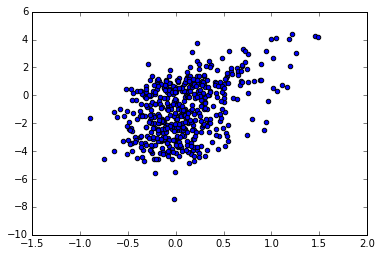

In [10]:
plt.scatter(predictvals, socialvals)
plt.show()

In [11]:
with open('../results/social2predictvals.tsv', mode = 'w', encoding = 'utf-8') as f:
    f.write('genre1\tgenre2\tsocialprox\tpredict\n')
    for idx, comp in enumerate(comparisons):
        g1, g2 = comp
        soc = socialvals[idx]
        pred = predictvals[idx]
        f.write(g1 + '\t' + g2 + '\t' + str(soc) + '\t' + str(pred) + '\n')

#### Calculate confidence interval on *r*

In [12]:
## Careful reading about confidence intervals has led me to conclude that bootstrapped
## results are not always reliable in this case. 

## I am relying instead on a function written by Zhiya Zuo, in this post:
## https://zhiyzuo.github.io/Pearson-Correlation-CI-in-Python/

# It matches results from cor.test in R.

from scipy import stats

def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

pearsonr_ci(np.array(predictvals), np.array(socialvals))

(0.45252114703459534,
 2.0742695439313944e-26,
 0.37960132021109044,
 0.5198531082142609)

### What if we allow overlap (genre intersection)?

This was a separate predictive run, saved as ```overlapcrosscomparisons.tsv.```

In [13]:
odict = dict()
for filepath in ['../results/overlapcrosscomparisons.tsv']:
    crosses = pd.read_csv(filepath, sep = '\t')
    for idx, row in crosses.iterrows():
        if row.testype.startswith('self'):
            continue
        g1 = row.name1.split('_')[0]
        g2 = row.name2.split('_')[0]

        if g1.startswith('random') or g2.startswith('random'):
            continue

        if g1 not in odict:
            odict[g1] = dict()

        if g2 not in odict:
            odict[g2] = dict()

        if g2 not in odict[g1]:
            odict[g1][g2] = [float(row.spearman)]
        else:
            odict[g1][g2].append(float(row.spearman))

        if g1 not in odict[g2]:
            odict[g2][g1] = [float(row.spearman)]
        else:
            odict[g2][g1].append(float(row.spearman))

avgwoverlap = dict()
for k1, v1 in odict.items():
    avgwoverlap[k1] = dict()
    for k2, v2 in v1.items():
        avgwoverlap[k1][k2] = sum(v2) / len(v2)

In [14]:
withoverlap = dict()

for g1 in primaries:
    if g1.startswith('random'):
        continue

    withoverlap[g1] = dict()
    
    for g2 in primaries:
        if g2.startswith('random'):
            continue
            
        if g1 == g2:
            bversion = g1 + ' B'
            if bversion in bgenres:
                withkey1 = compress(g1)
                withkey2 = compress(bversion)
            else:
                withoverlap[g1][g1] = float('nan')
                continue  
                
        else:
            withkey1 = compress(g1)
            withkey2 = compress(g2)

        if withkey1 in avgwoverlap and withkey2 in avgwoverlap[withkey1]:
            withoverlap[g1][g2] = avgwoverlap[withkey1][withkey2]
        else:
            withoverlap[g1][g2] = float('nan')
            print('error', g1, g2, withkey1, withkey2)
        
        
        

In [15]:
withmatrix = pd.DataFrame(withoverlap)
withmatrix

,Adventure,Bildungsroman,Biographical,Christian,Domestic,Fantasy,Historical,Horror,Humor,Juvenile,...,Subj: Humor,Subj: Juvenile,Subj: Man-woman,"Subj: SF, American","Subj: SF, Other","Subj: Short stories, American","Subj: Short stories, Other",Suspense,War,Western
Adventure,NaN,-0.089374,0.062906,-0.088186,-0.360672,0.445826,0.113316,0.541967,0.034001,0.183723,...,0.100743,0.149980,-0.433253,0.744202,0.875582,0.260021,-0.372226,0.800998,0.596862,0.661921
Bildungsroman,-0.089374,0.752103,-0.242454,-0.098786,0.573723,-0.265496,-0.268682,-0.002656,0.255883,0.022433,...,0.084803,0.174567,0.320883,-0.150948,-0.260595,0.382052,-0.252510,-0.031086,-0.271868,0.020310
Biographical,0.062906,-0.242454,NaN,0.025658,-0.327723,0.536520,0.694278,0.096480,-0.427395,-0.179598,...,-0.271567,-0.238282,-0.304188,-0.043181,-0.089314,-0.041788,0.183456,-0.461443,0.394171,0.330647
Christian,-0.088186,-0.098786,0.025658,NaN,0.270747,0.288671,0.276808,0.021624,-0.008394,0.357926,...,-0.353772,0.222926,0.118027,0.245135,0.099948,-0.141680,-0.407849,0.012638,-0.020547,0.271194
Domestic,-0.360672,0.573723,-0.327723,0.270747,0.943536,-0.467619,-0.171254,-0.184249,0.217702,0.185440,...,-0.069471,0.308703,0.527450,-0.255644,-0.462879,0.292616,-0.229332,-0.016491,-0.332612,0.002859
Fantasy,0.445826,-0.265496,0.536520,0.288671,-0.467619,1.335442,0.549064,0.752502,-0.312604,0.034995,...,-0.454329,-0.002955,-0.255082,0.960463,1.167167,-0.067549,-0.158386,-0.005233,0.460792,0.488347
Historical,0.113316,-0.268682,0.694278,0.276808,-0.171254,0.549064,0.902016,-0.025590,-0.510945,0.344883,...,-0.414515,0.328506,-0.367657,-0.141440,-0.126151,-0.131110,0.003690,-0.214186,0.459537,0.649634
Horror,0.541967,-0.002656,0.096480,0.021624,-0.184249,0.752502,-0.025590,NaN,-0.087847,-0.117164,...,-0.260145,-0.142979,-0.184749,0.832844,0.934778,0.349977,-0.173057,0.479396,0.192900,0.378327
Humor,0.034001,0.255883,-0.427395,-0.008394,0.217702,-0.312604,-0.510945,-0.087847,1.138995,-0.091322,...,1.042515,-0.164752,0.291022,0.011838,-0.012730,-0.021625,-0.547463,0.203187,-0.361391,-0.310805
Juvenile,0.183723,0.022433,-0.179598,0.357926,0.185440,0.034995,0.344883,-0.117164,-0.091322,1.040070,...,0.220420,1.325600,-0.375056,0.012056,-0.012016,0.158342,-0.068255,0.027415,0.234068,0.362044


Not using the diagonal: 
(0.46418034484518667, 7.1532229394694264e-28) n = 496


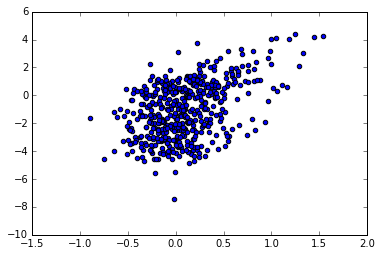

In [18]:
socialvals, overlapvals, comparisons = compare_to_social(social, withmatrix)
print('Not using the diagonal: ')
print(pearsonr(socialvals, overlapvals), 'n = ' + str(len(overlapvals)))
plt.scatter(overlapvals, socialvals)
plt.show()

That's a slightly stronger correlation, although we're no longer as confident that textual and social measures are independent. For actual historical research that might not matter; it matters for our methodological inquiry here.

### Using more data

But let's think about what we might do in actual historical research. Actually, once we allow genres to overlap, it allows a more aggressive approach to the data. We have B samples for 25 genres, so instead of delicately comparing two non-overlapping sets, we can compare multiple samples:

    Genre 1 sample A -> Genre 2 sample A
    Genre 1 sample B -> Genre 2 sample B
    Genre 1 sample A -> Genre 2 sample B
    Genre 1 sample B -> Genre 2 sample A

This gets us a bit more accuracy.

In [19]:
# Now let's use all the comparisons.

allcomparisons = dict()

for g1 in bgenres:
    bless1 = g1[0 : -2]
    allcomparisons[bless1] = dict()
    
    for g2 in bgenres:
        bless2 = g2[0 : -2]
        
        bkey1 = compress(bless1)
        bkey2 = compress(bless2)
        key1 = compress(g1)
        key2 = compress(g2)
        
        allcomparisons[bless1][bless2] = []
        allcomparisons[bless1][bless2].append(avgwoverlap[key1][bkey2])
        allcomparisons[bless1][bless2].append(avgwoverlap[bkey1][key2])
        if not g1 == g2:
            allcomparisons[bless1][bless2].append(avgwoverlap[bkey1][bkey2])
            allcomparisons[bless1][bless2].append(avgwoverlap[key1][key2])
        
        allcomparisons[bless1][bless2] = sum(allcomparisons[bless1][bless2]) / len(allcomparisons[bless1][bless2])

allmatrix = pd.DataFrame(allcomparisons)
allmatrix

,Bildungsroman,Domestic,Fantasy,Historical,Humor,Juvenile,Love,Mystery,Novel,Psychological,...,Subj: History,Subj: Horror,Subj: Humor,Subj: Juvenile,Subj: Man-woman,"Subj: SF, American","Subj: SF, Other","Subj: Short stories, American","Subj: Short stories, Other",Suspense
Bildungsroman,0.752103,0.695285,-0.279645,-0.249937,0.177597,0.054758,0.354199,0.024972,-0.122689,0.389902,...,-0.436131,-0.062553,0.158681,0.100237,0.318998,-0.111836,-0.275698,0.439505,-0.168517,-0.052127
Domestic,0.695285,0.943536,-0.469475,-0.229198,0.172577,0.265088,0.568052,0.124253,-0.142838,0.467646,...,-0.568450,-0.190011,0.017256,0.262299,0.519983,-0.247614,-0.478340,0.310728,-0.232260,-0.010400
Fantasy,-0.279645,-0.469475,1.335442,0.488326,-0.336909,0.076545,-0.082691,-0.146981,0.222013,-0.204011,...,0.529632,0.636098,-0.475572,0.152093,-0.380047,0.861682,1.036809,-0.021803,-0.119503,0.036439
Historical,-0.249937,-0.229198,0.488326,0.902016,-0.473623,0.182348,-0.107611,-0.286287,0.096480,-0.453047,...,0.686006,-0.087528,-0.405862,0.245175,-0.403724,-0.229708,-0.193842,-0.090226,0.033185,-0.211710
Humor,0.177597,0.172577,-0.336909,-0.473623,1.138995,-0.035273,0.058404,0.422370,-0.060326,0.272532,...,-0.428494,-0.190323,1.037500,-0.114211,0.320138,0.078223,0.051536,0.018448,-0.530738,0.238953
Juvenile,0.054758,0.265088,0.076545,0.182348,-0.035273,1.040070,-0.235468,-0.088830,0.008029,-0.279019,...,0.162719,-0.198485,0.247369,1.158535,-0.277355,-0.065800,-0.160729,0.213250,-0.052234,0.072321
Love,0.354199,0.568052,-0.082691,-0.107611,0.058404,-0.235468,0.795763,0.146600,0.081726,0.326868,...,-0.364840,-0.029811,-0.360389,-0.179908,0.626659,-0.032486,-0.240995,0.025568,-0.367467,-0.000316
Mystery,0.024972,0.124253,-0.146981,-0.286287,0.422370,-0.088830,0.146600,1.413493,0.224118,0.322704,...,-0.256106,0.264191,0.312916,-0.138421,0.076221,0.244745,0.141918,-0.010669,-0.681936,1.136160
Novel,-0.122689,-0.142838,0.222013,0.096480,-0.060326,0.008029,0.081726,0.224118,0.226494,-0.065787,...,0.156029,0.051842,-0.232472,-0.003301,-0.091933,0.070518,0.066252,-0.155141,-0.214052,0.247870
Psychological,0.389902,0.467646,-0.204011,-0.453047,0.272532,-0.279019,0.326868,0.322704,-0.065787,0.660100,...,-0.521001,0.141132,0.005631,-0.272788,0.392891,0.200231,0.161158,0.195254,-0.317172,0.207924


Not using the diagonal: 
(0.53334264036356527, 1.8830206091795615e-23) n = 300


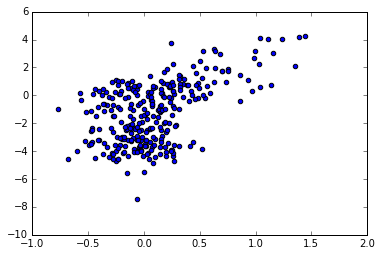

In [21]:
socialvals, datarichvals, comparisons = compare_to_social(social, allmatrix)
print('Not using the diagonal: ')
print(pearsonr(socialvals, datarichvals), 'n = ' + str(len(datarichvals)))
plt.scatter(datarichvals, socialvals)
plt.show()

### Mapping genres in two dimensions

This is relatively easy with multidimensional scaling.

But first, we need a matrix whose cells can be interpreted as positive "distances." Our existing matrix is sometimes negative, and worse, the biggest numbers are the *closest* comparisons. We need to flip that, like so:

In [22]:
sansmatrix.fillna(0, inplace = True)
negativepart = sansmatrix.values.min()
vizmatrix = sansmatrix - negativepart
maximumvalue = vizmatrix.values.max()
vizmatrix = maximumvalue - vizmatrix
for idx in vizmatrix.index:
    vizmatrix.loc[idx, idx] = 0
    # diagonal should be zero for this purpose

In [23]:
vizmatrix

,Adventure,Bildungsroman,Biographical,Christian,Domestic,Fantasy,Historical,Horror,Humor,Juvenile,...,Subj: Humor,Subj: Juvenile,Subj: Man-woman,"Subj: SF, American","Subj: SF, Other","Subj: Short stories, American","Subj: Short stories, Other",Suspense,War,Western
Adventure,0.000000,1.777847,1.718401,1.793862,2.071062,1.221882,1.486000,1.163709,1.671675,1.521953,...,1.604933,1.555696,2.170206,0.961474,0.830094,1.445655,2.077902,0.904678,1.204188,1.157812
Bildungsroman,1.777847,0.000000,1.948130,1.804462,1.124193,1.971172,1.974358,1.708332,1.589620,1.683243,...,1.620873,1.531109,1.448997,1.856624,1.966271,1.323624,1.958186,1.790750,2.000363,1.685366
Biographical,1.718401,1.948130,0.000000,1.532363,2.033399,1.169157,1.009559,1.609196,2.133071,1.885274,...,1.977243,1.943958,2.009864,1.748857,1.794990,1.747464,1.522220,2.167119,1.274681,1.484902
Christian,1.793862,1.804462,1.532363,0.000000,1.683885,1.342774,1.428869,1.684052,1.807578,1.347750,...,2.059448,1.482750,1.587649,1.460542,1.605728,1.847356,2.113525,1.693038,1.726223,1.434482
Domestic,2.071062,1.124193,2.033399,1.683885,0.000000,2.173295,1.876930,1.889925,1.487974,1.520236,...,1.775147,1.396973,1.186084,1.961320,2.168555,1.413061,1.935009,1.722168,2.020034,1.702817
Fantasy,1.221882,1.971172,1.169157,1.342774,2.173295,0.000000,1.156612,1.018663,2.018280,1.670681,...,2.160005,1.708631,1.960758,0.745213,0.538509,1.773225,1.864062,1.710909,1.201032,1.217329
Historical,1.486000,1.974358,1.009559,1.428869,1.876930,1.156612,0.000000,1.731266,2.216621,1.360793,...,2.120191,1.377170,2.080518,1.847117,1.831827,1.836786,1.701986,1.919862,1.219098,1.056042
Horror,1.163709,1.708332,1.609196,1.684052,1.889925,1.018663,1.731266,0.000000,1.793523,1.822840,...,1.965821,1.848656,1.890425,0.782088,0.766251,1.355699,1.878733,1.226281,1.512776,1.424180
Humor,1.671675,1.589620,2.133071,1.807578,1.487974,2.018280,2.216621,1.793523,0.000000,1.796998,...,0.663161,1.870428,1.414654,1.693838,1.718406,1.727301,2.253139,1.502489,2.067067,2.016481
Juvenile,1.521953,1.683243,1.885274,1.347750,1.520236,1.670681,1.360793,1.822840,1.796998,0.000000,...,1.485256,0.453834,2.080732,1.693620,1.717692,1.547334,1.773932,1.678261,1.471608,1.343632


In [24]:
sansmatrix.fillna(0, inplace = True)
negativepart = sansmatrix.values.min()
vizmatrix = sansmatrix - negativepart
maximumvalue = vizmatrix.values.max()
vizmatrix = maximumvalue - vizmatrix
for idx in vizmatrix.index:
    vizmatrix.loc[idx, idx] = 0
    # diagonal should be zero for this purpose
scaler = MDS(metric = True, dissimilarity = 'precomputed')
coordinates = scaler.fit_transform(vizmatrix)

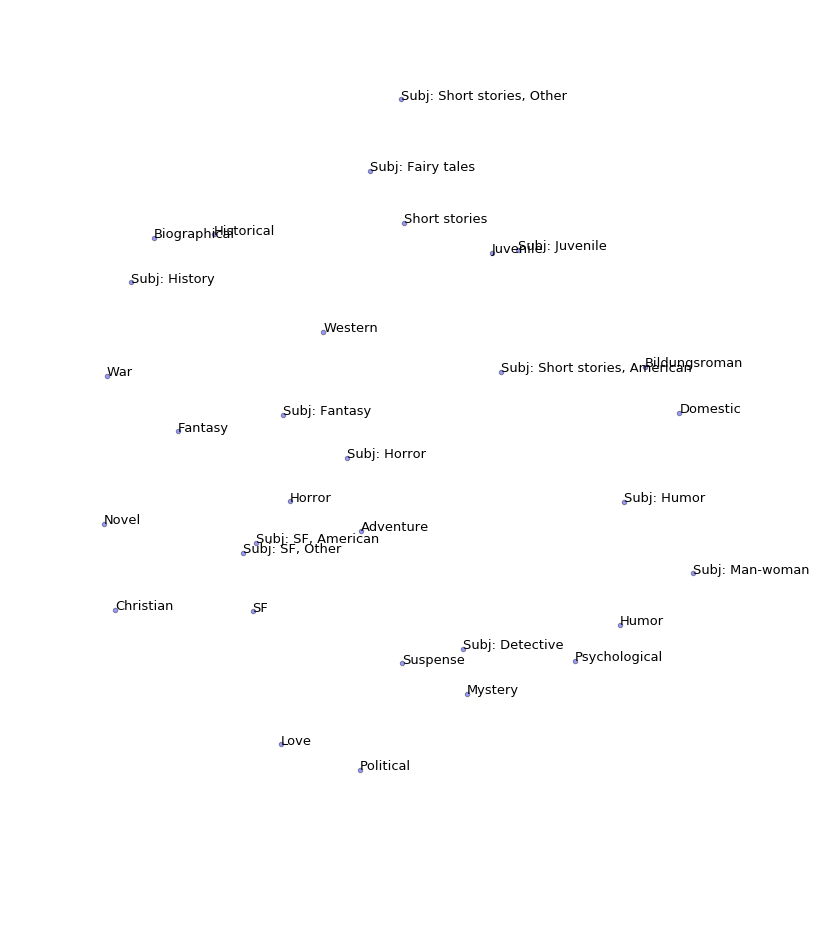

In [25]:
fig, ax = plt.subplots(figsize = (14, 16))
genres = vizmatrix.index.tolist()
colors=np.linspace(0, 1, 7)
ax.scatter(coordinates[ :, 0], coordinates[ : , 1], alpha = 0.4)

for i in range(len(genres)):
    thisx = coordinates[i, 0]
    thisy = coordinates[i, 1]
    name = genres[i]
    ax.annotate(name, (thisx, thisy), fontsize = 13)
plt.axis('off')
plt.show()

It's notable that some genres are very tightly clustered: different versions of science fiction and mystery, for instance. On the other hand, realist genres—e.g. "Short stories"—can be spread out more.

In [ ]:
# Write the map to file

with open('../results/predictivetopicmap.tsv', mode = 'w', encoding = 'utf-8') as f:
    f.write('genre\tmeandate\txcord\tycord\n')
    for i, genre in enumerate(genres):
        xcord = str(coordinates[i, 0])
        ycord = str(coordinates[i, 1])
        meandate = str(genrenamedf.loc[genrenamedf.genre == genre, 'meandate'].values[0])
        f.write(genre + '\t' + meandate + '\t' + xcord + '\t' + ycord + '\n')

### A strictly social map

In [26]:
social.fillna(0, inplace = True)
negativepart = social.values.min()
vizmatrix = social - negativepart
maximumvalue = vizmatrix.values.max()
vizmatrix = maximumvalue - vizmatrix
for idx in vizmatrix.index:
    vizmatrix.loc[idx, idx] = 0
    # diagonal should be zero for this purpose
scaler = MDS(metric = True, dissimilarity = 'precomputed')
coordinates = scaler.fit_transform(vizmatrix)

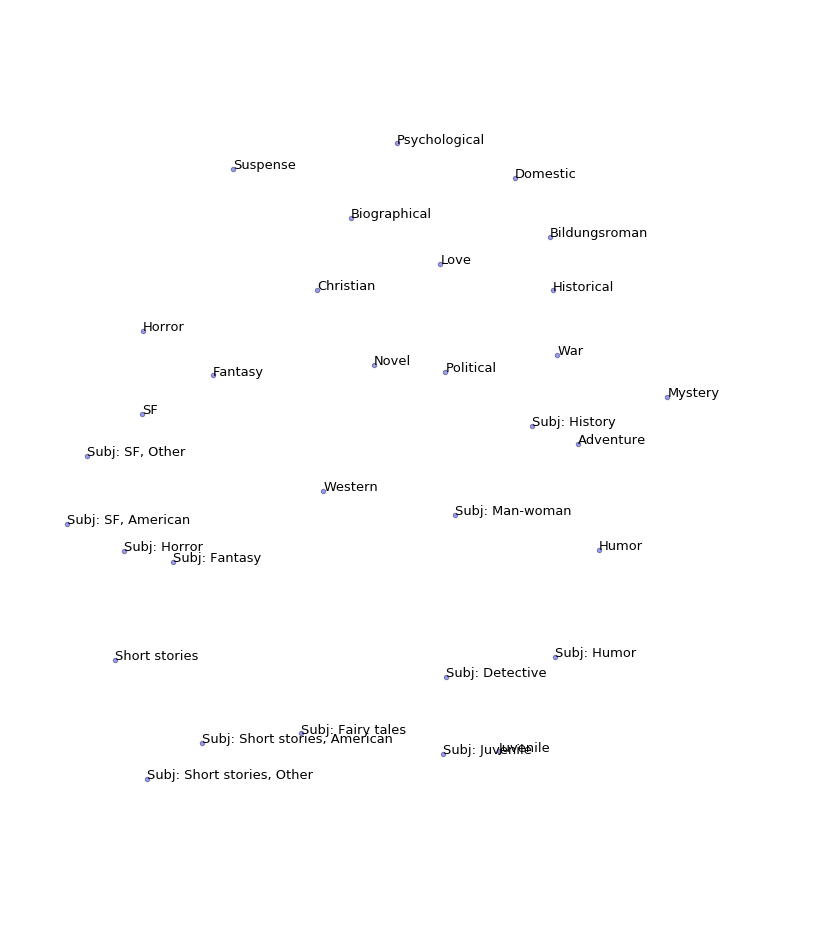

In [27]:
fig, ax = plt.subplots(figsize = (14, 16))
genres = vizmatrix.index.tolist()
colors=np.linspace(0, 1, 7)
ax.scatter(coordinates[ :, 0], coordinates[ : , 1], alpha = 0.4)

for i in range(len(genres)):
    thisx = coordinates[i, 0]
    thisy = coordinates[i, 1]
    name = genres[i]
    ax.annotate(name, (thisx, thisy), fontsize = 13)
plt.axis('off')
plt.show()

I'm not convinced that is preferable to the predictive map! Look, for instance, at Subj: Detective and Mystery, separated by Humor. Look also at Humor and Subj: Humor. I think my priors about generic similarity across time might have been too weak.

In [ ]:
# Write the map to file

with open('../results/socialmap.tsv', mode = 'w', encoding = 'utf-8') as f:
    f.write('genre\tmeandate\txcord\tycord\n')
    for i, genre in enumerate(genres):
        xcord = str(coordinates[i, 0])
        ycord = str(coordinates[i, 1])
        meandate = str(genrenamedf.loc[genrenamedf.genre == genre, 'meandate'].values[0])
        f.write(genre + '\t' + meandate + '\t' + xcord + '\t' + ycord + '\n')

### Just noodling around

Ignore the calculations below. They weren't used in the article.

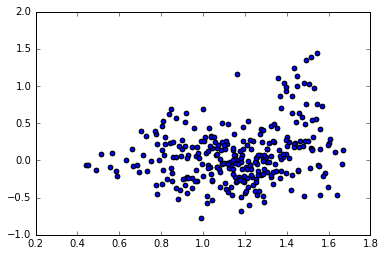

In [28]:
selfavg = []
compared = []
socvals = []

for idx1 in allmatrix.index:
    for idx2 in allmatrix.index:
        if idx1 == idx2:
            continue
            
        self1 = allmatrix.loc[idx1, idx1]
        self2 = allmatrix.loc[idx2, idx2]
        compare = allmatrix.loc[idx1, idx2]
        
        if pd.isnull(self1) and pd.isnull(self2):
            continue
        elif pd.isnull(self1):
            theself = self2
        elif pd.isnull(self2):
            theself = self1
        else:
            theself = (self1 + self2) / 2
        
        compared.append(compare)
        selfavg.append(theself)
        socvals.append(social.loc[idx1, idx2])

plt.scatter(selfavg, compared)

In [29]:
pearsonr(selfavg, socvals)

(0.021197636080041094, 0.60431219482369003)

In [30]:
pearsonr(selfavg, compared)

(0.23562931956635333, 5.1535770029047557e-09)

In [31]:
df = pd.DataFrame({'x': selfavg, 'y': compared})
X = df[['x']]
y = df['y']
mod = sm.OLS(y, X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     38.54
Date:                Fri, 06 Jul 2018   Prob (F-statistic):           1.00e-09
Time:                        21:46:18   Log-Likelihood:                -257.62
No. Observations:                 600   AIC:                             517.2
Df Residuals:                     599   BIC:                             521.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x              0.0793      0.013      6.208      0.000       0.054       0.104
==============================================================================
Omnibus:                       85.326   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              132.173
Skew:                           0.930   Prob(JB):                     1.99e-29
Kurtosis:                       4.352   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
adjusted = np.array(compared) - (np.array(selfavg) * .278)

In [33]:
pearsonr(adjusted, socvals)

(0.5440410426854505, 1.5990582235379594e-47)